In [1]:
from dotenv import load_dotenv

load_dotenv()

True

#### Creating VectorDatabase

In [2]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "restaurant_info.txt"}
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "restaurant_info.txt"}
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"}
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"}
    ),
]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever()

In [3]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    question: str
    grades: list[bool]
    llm_output: str
    documents: list[str]
    on_topic: bool

In [4]:
def retrieve_docs(state: AgentState):
    question = state["question"]
    documents = retriever.get_relevant_documents(query=question)
    state["documents"] = [doc.page_content for doc in documents]
    return state

In [5]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the restaurant Bella Vista"""

    score: str = Field(
        description="Question is about restaurant? If yes -> 'True' if not -> 'False'"
    )

def question_classifier(state: AgentState):
    print("question_classifier")
    question = state["question"]

    system = """You are a grader assessing the relevance of a retrieved document to a user question. \n
        Only answer if the question is about one of the following topics:
        1. Information about the owner of Bella Vista (Antonio Rossi).
        2. Prices of dishes at Bella Vista.
        3. Opening hours of Bella Vista.
        4. Available menus at Bella Vista.

        If the question IS about these topics response with "True", otherwise respond with "False".
        """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = ChatOpenAI()
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.score
    return state


In [6]:
def on_topic_router(state: AgentState):
    print("on_topic_router")
    on_topic = state["on_topic"]
    if bool(on_topic):
        return "on_topic"
    return "off_topic"

In [7]:
def off_topic_response(state: AgentState):
    state["llm_output"] = "I cant respond to that!"
    return state

In [8]:
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description="Documents are relevant to the question, 'True' or 'False'"
    )

def document_grader(state: AgentState):
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'True' or 'False' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    llm = ChatOpenAI()
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        score = bool(result.score)
        scores.append(score)
    state["grades"] = scores
    return state

In [9]:
def gen_router(state: AgentState):
    grades = state["grades"]
    if all(grades):
        return "generate"
    else:
        return "rewrite_query"

In [10]:
from langchain_core.output_parsers import StrOutputParser


def rewriter(state: AgentState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = ChatOpenAI()
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

def generate_answer(state: AgentState):
    llm = ChatOpenAI()
    question = state["question"]
    docs = state["documents"]
    print("DOCS:", docs)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": docs})
    state["llm_output"] = result
    return state

In [12]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()

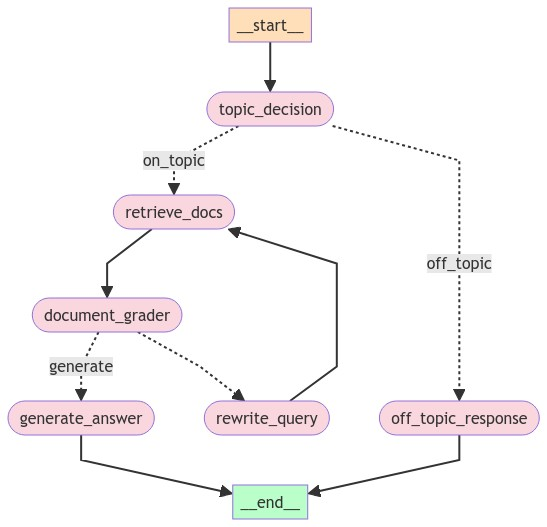

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [15]:
result = app.invoke({"question": "who is the owner of the Bella vista??"})
result["llm_output"]

question_classifier
Classified topic as on topic, true or false?:  True
on_topic_router
retrieve_docs
document_grader
gen_router
generate_answer
DOCS: ['Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.', 'Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.', 'Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.', 'Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and

'Antonio Rossi'